In [1]:
from pytorch_grad_cam.grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

In [2]:
from torchvision.models import efficientnet_b5
import torchvision.transforms as transforms

In [3]:
import numpy as np
from PIL import Image

In [4]:
import torch

def model_load_checkpoint(model, path):
    checkpoint = torch.load(path, map_location=torch.device('cpu'))
    model.load_state_dict(checkpoint['model'])
    return model

def reshape_transform(tensor, height=14, width=14):
    result = tensor[:, 1:, :].reshape(tensor.size(0),
                                      height, width, tensor.size(2))

    # Bring the channels to the first dimension,
    # like in CNNs.
    result = result.transpose(2, 3).transpose(1, 2)
    return result

In [5]:
def plot_grad_cam(model, target_class, img, dim=224, save_path=None):
    """
    img: PIL image
    """
    
    model.eval()
    
    if model.__class__.__name__ == 'ResNet':
        target_layers = [model.layer4[-1]]
    elif model.__class__.__name__ == 'EfficientNet':
        target_layers = [model.features[-2][-2]]
    elif model.__class__.__name__ == 'VisionTransformer':
        target_layers = [model.encoder.layers.encoder_layer_11.ln_1]
    else:
        raise ValueError('Model not supported')
    
    if model.__class__.__name__ == 'VisionTransformer':
        cam = GradCAM(model=model, target_layers=target_layers,reshape_transform=reshape_transform)
    else:
        cam = GradCAM(model=model, target_layers=target_layers)

    transform = transforms.Compose([
        transforms.Resize((dim, dim)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])

    input_tensor = transform(img)

    targets = [ClassifierOutputTarget(target_class)]

    grayscale_cam = cam(input_tensor=input_tensor.unsqueeze(0), targets=targets, eigen_smooth=True)
    grayscale_cam = grayscale_cam[0, :]

    img = img.resize((dim, dim))
    img = np.float32(img) / 255

    cam_image_array = show_cam_on_image(img, grayscale_cam, use_rgb=True)

    cam_image = Image.fromarray(cam_image_array)
    
    if save_path:
        cam_image.save(save_path)
    
    return cam_image

In [6]:
import torch

In [7]:
from torchvision.datasets import Flowers102
data = Flowers102(root="/home/peppe/01_Study/01_University/Semester/2/Intro_to_ML/Project/data", download=True)

In [8]:
# with resnet50
model = efficientnet_b5(weights=None)
model.classifier[1] = torch.nn.Linear(2048, 102, bias=True)
model = model_load_checkpoint(model, "/home/peppe/01_Study/01_University/Semester/2/Intro_to_ML/Project/Code/experiments/effnetb5_Flowers102_SAM/checkpoint.pth")

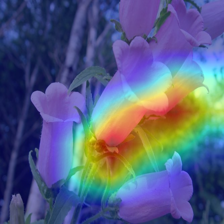

In [14]:
plot_grad_cam(model=model,target_class=60, img=data[20][0])